In [ ]:
pip install Node2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1

In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data =pd.read_csv('/content/disease_symptoms.csv',encoding='unicode_escape')
data.head()

,Diseases,Symptoms
0,abscess,"pain (0.318), fever (0.119), swelling (0.112),..."
1,acid reflux,"pain (0.225), nausea (0.140), pain in upper ab..."
2,acute renal failure,"kidney failure (0.127), weakness (0.087), diar..."
3,alcohol intoxication,"slurred speech (0.071), vomiting (0.064), unst..."
4,alcoholism,"seizures (0.125), depression (0.090), sadness ..."


function to extract the top 4 symptoms for the given disease

In [2]:
def extract_top_symptoms_for_disease(df, disease_name, top_n=4):
    row = data[data['Diseases'].isin(disease_name)]
    if row.empty:
        print(f"Disease '{disease_name}' not found in the DataFrame.")
        return []

    symptoms_with_weights = row.iloc[0]['Symptoms'].split(', ')
    top_symptoms = []
    for symptom_with_weight in symptoms_with_weights:
        symptom, _ = symptom_with_weight.split('(')
        top_symptoms.append(symptom.strip())
    return top_symptoms[:top_n]

disease_name = ["acid reflux"]

top_true_symptoms = extract_top_symptoms_for_disease(data, disease_name)
print(f"Top symptoms for {disease_name}: {top_true_symptoms}")

Top symptoms for ['acid reflux']: ['pain', 'nausea', 'pain in upper abdomen', 'abdominal pain']


Function for extracting top 4 symptoms for all the disease in the data

In [3]:
def extract_top_symptoms_for_all_diseases(df, top_n=4):
    top_symptoms_dict = {}
    for index, row in df.iterrows():
        disease_name = [row['Diseases']]
        top_symptoms = extract_top_symptoms_for_disease(df, disease_name, top_n)
        top_symptoms_dict[row['Diseases']] = top_symptoms
    return top_symptoms_dict

top_true_symptoms_all_diseases = extract_top_symptoms_for_all_diseases(data)

# Constructing Knowledge Graph

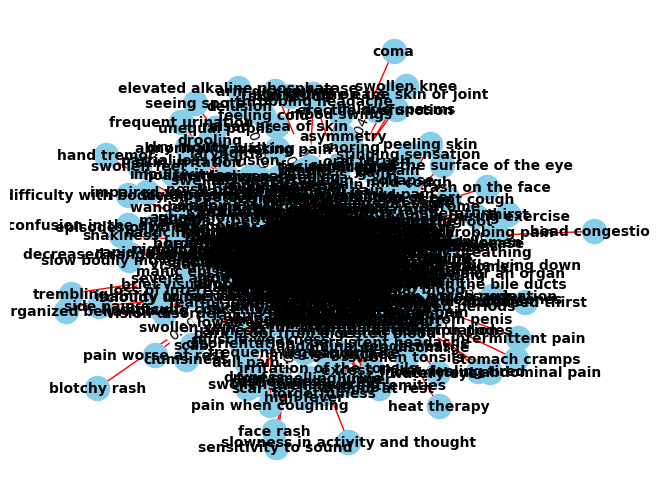

In [ ]:
G = nx.Graph()
for index, row in data.iterrows():
  disease = row["Diseases"]
  symptoms = row["Symptoms"].split(",")
  G.add_node(disease, type='disease')
  #print(symptoms)
  for symptom in symptoms:
    symptom, score = symptom.strip().split("(")
    score = float(score[:-1])
    symptom = symptom.strip()
    #print(symptom, score)
    G.add_node(symptom, type='symptom')
    G.add_edge(symptom, disease, weight=score)


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True,  node_color="skyblue",edge_color ='red',font_weight = 'bold', font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [ ]:
num_nodes = nx.number_of_nodes(G)
print("Number of nodes in the graph:", num_nodes)

Number of nodes in the graph: 486


In [ ]:
num_edges = nx.number_of_edges(G)
print("Number of nodes in the graph:", num_edges)

Number of nodes in the graph: 3709


In [ ]:
disease_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'disease']
symptom_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'symptom']

In [ ]:
#print(symptom_nodes)

In [ ]:
num_disease = len(np.unique(disease_nodes))
num_symptoms= len(np.unique(symptom_nodes))


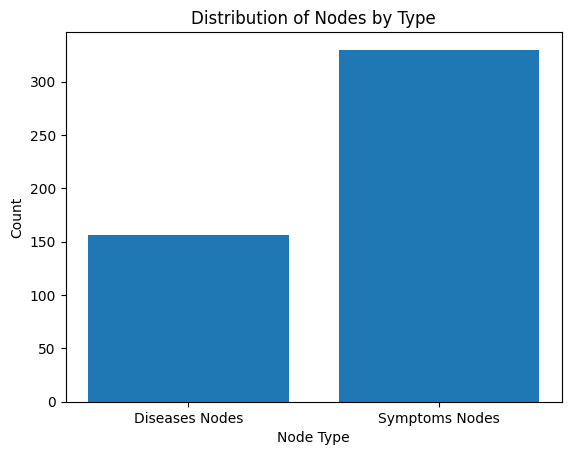

In [ ]:
plt.bar(['Diseases Nodes', 'Symptoms Nodes'], [num_disease, num_symptoms])
plt.xlabel('Node Type')
plt.ylabel('Count')
plt.title('Distribution of Nodes by Type')
plt.show()

Creating Dataframe that stores list of disease for each symptoms

This will be used as ground truth labels when calculating the accuracy for disease prediction

In [ ]:
symptom_disease_dict = {}

for node in G.nodes():
    if G.nodes[node]['type'] == 'symptom':
      diseases_weights_str = ""
      diseases_weights = []
      for neighbor in G.neighbors(node):
        if G.nodes[neighbor]['type'] == 'disease':
          disease_name = neighbor
          edge_weight = G.edges[node, neighbor]['weight']
          diseases_weights.append((disease_name, edge_weight))
      sorted_diseases_weights = sorted(diseases_weights, key=lambda x: x[1], reverse=True)
      diseases_weights_str = ", ".join([f"{disease} ({weight})" for disease, weight in sorted_diseases_weights])
      symptom_disease_dict[node] = diseases_weights_str

df = pd.DataFrame(symptom_disease_dict.items(), columns=['Symptoms', 'Diseases_Weights'])
df

,Symptoms,Diseases_Weights
0,pain,"appendicitis (0.881), ovarian cyst (0.785), pa..."
1,fever,"strep throat (0.347), neutropenia (0.344), men..."
2,swelling,"sprained ankle (0.461), cellulitis (0.404), sp..."
3,redness,"cellulitis (0.508), pink eye (0.318), insect b..."
4,chills,"kidney infection (0.287), strep throat (0.215)..."
...,...,...
325,excess urination,"type 1 diabetes (0.012), type 2 diabetes (0.007)"
326,increased thirst,"type 1 diabetes (0.007), type 2 diabetes (0.003)"
327,scarring within the bile ducts,ulcerative colitis (0.027)
328,cloudy urine,urinary tract infection (0.01)


function to extract the top 4 disease for the given symptom from above dataframe

In [ ]:
def extract_top_disease_for_symptoms(df, symptom_list, top_n=4):
    row = df[df['Symptoms'].isin(symptom_list)]
    if row.empty:
        print(f"symptom '{disease_name}' not found in the DataFrame.")
        return []
    diseases_with_weights = row.iloc[0]['Diseases_Weights'].split(', ')
    top_diseases = []
    for disease_with_weight in diseases_with_weights:
        disease, _ = disease_with_weight.split('(')
        top_diseases.append(disease.strip())
    return top_diseases[:top_n]

symptom_name = ["pain"]
top_true_diseases = extract_top_disease_for_symptoms(df, symptom_name)
print(f"Top symptoms for {symptom_name}: {top_true_diseases}")

Top symptoms for ['pain']: ['appendicitis', 'ovarian cyst', 'pancreatitis', 'sickle cell anemia']


In [ ]:
def extract_top_diseases_for_all_symptoms(df, top_n):
    top_diseases_dict = {}
    for index, row in df.iterrows():
        symptom_name = [row['Symptoms']]
        top_diseases = extract_top_disease_for_symptoms(df, symptom_name, top_n)
        top_diseases_dict[row['Symptoms']] = top_diseases
    return top_diseases_dict
top_n=4
top_true_disease_all_symptoms = extract_top_diseases_for_all_symptoms(df,top_n)
#top_true_symptoms_all_diseases

# Graph Traversal for disease prediction

Traversing the graph to extract the top 4 disease for the given symptom based on the edge weight

In [ ]:
from collections import defaultdict

def find_top_diseases(symptom_list):
    top_disease_list = []
    disease_weights = defaultdict(float)

    for symptom in symptom_list:
        if symptom not in G.nodes:
            continue
        associated_diseases = [neighbor for neighbor in G.neighbors(symptom) if G.nodes[neighbor]['type'] == 'disease']
        for disease in associated_diseases:
            weight = G.edges[(symptom, disease)]['weight']
            # Adding the weight to the aggregated weights for the disease
            disease_weights[disease] += weight

    # Sorting in descending order
    sorted_diseases = sorted(disease_weights.items(), key=lambda x: x[1], reverse=True)
    top_disease = [disease for disease, _ in sorted_diseases[:4]]
    top_disease_list.append((top_disease))
    # return top 4 disease
    return top_disease_list

symptoms = ["pain"]
result = find_top_diseases(symptoms)
print(result)


[['appendicitis', 'ovarian cyst', 'pancreatitis', 'sickle cell anemia']]


# Graph Traversal for symptom prediction

Traversing the graph to extract the top 4 symptoms for the given disease based on the edge weight.

In [ ]:
def predict_top_symptoms(disease_list):
    top_symptoms_list = []
    for disease in disease_list:
        if disease not in G.nodes:
            continue
        symptom_weights = defaultdict(float)
        associated_symptoms = [neighbor for neighbor in G.neighbors(disease) if G.nodes[neighbor]['type'] == 'symptom']
        for symptom in associated_symptoms:
            weight = G.edges[(disease, symptom)]['weight']
            symptom_weights[symptom] += weight

        sorted_symptoms = sorted(symptom_weights.items(), key=lambda x: x[1], reverse=True)
        top_symptoms = [symptom for symptom, _ in sorted_symptoms[:4]]
        top_symptoms_list.append((top_symptoms))

    return top_symptoms_list

diseases = [ "acid reflux"]
result = predict_top_symptoms(diseases)
print(result)

[['pain', 'nausea', 'pain in upper abdomen', 'abdominal pain']]


# Exracting disease and symptoms using Node Embeddings

In [ ]:
from node2vec import Node2Vec
import torch
# Generating node embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=50, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/486 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
node_embeddings = {node: model.wv[node] for node in G.nodes}
# Embeddings for both the disease and symptoms nodes
disease_embeddings= {node: model.wv[node] for node in G.nodes() if G.nodes[node]['type'] == 'disease'}
symptom_embeddings = {node: model.wv[node] for node in G.nodes() if G.nodes[node]['type'] == 'symptom'}

In [ ]:
node_embeddings_tensor = torch.tensor([node_embeddings[node] for node in node_embeddings], dtype=torch.float)

# Visualization of Node Embeddings

In [ ]:
node_embeddings_array = node_embeddings_tensor.numpy()
#node_embeddings_array

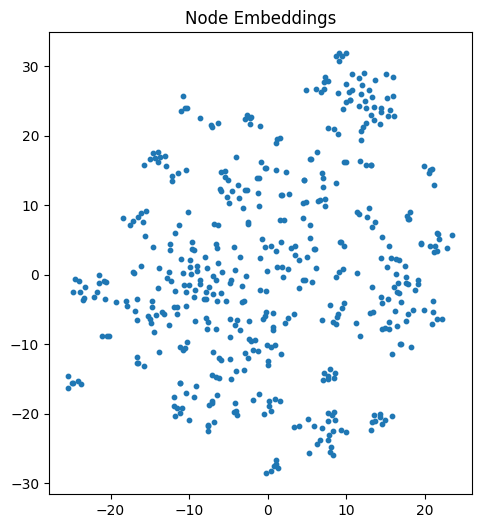

In [ ]:
#Visualization of node embeddings in 2D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne= tsne.fit_transform(node_embeddings_array)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=10)
plt.title('Node Embeddings')
plt.show()


# Predicting symptoms based on disease

Computing the similarity between embeddings of the input diseases with all the symptoms embeddings.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings, disease_list, top_n=4):
    all_similarities = {}
    for disease in disease_list:
        if disease in disease_embeddings:
            disease_embedding = disease_embeddings[disease]
            for symptom_node, symptom_embedding in symptom_embeddings.items():
                similarity = cosine_similarity([disease_embedding], [symptom_embedding])[0][0]
                if symptom_node not in all_similarities:
                    all_similarities[symptom_node] = similarity
                else:
                    all_similarities[symptom_node] += similarity
    # ranking symptoms based on accumulated similarities
    ranked_symptoms = sorted(all_similarities.items(), key=lambda x: x[1], reverse=True)

    # return top predicted symptoms
    top_predicted_symptoms = [symptom for symptom, _ in ranked_symptoms[:top_n]]
    return top_predicted_symptoms

disease_name = ["acid reflux"]

top_predicted_symptoms = predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings, disease_name)
print(top_predicted_symptoms)

['heartburn', 'indigestion', 'peeling skin', 'heat therapy']


In [ ]:
def extract_top_symptoms_for_all_diseases(G, symptom_embeddings, top_n=4):
    top_symptoms_dict = {}
    for node in G.nodes():
        if G.nodes[node]['type'] == 'disease':
            disease_nodes = [node]
            #print(disease_nodes)
            top_symptoms = predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings, disease_nodes)
            #print(top_symptoms)
            top_symptoms_dict[node] = top_symptoms
            #print(top_symptoms_dict)
    return top_symptoms_dict

predicted_symptoms_all_diseases = extract_top_symptoms_for_all_diseases(G, symptom_embeddings)
#predicted_symptoms_all_diseases

In [ ]:
def calculate_accuracy(true_symptoms, predicted_symptoms, num_items):
    true_symptoms = true_symptoms[:num_items]
    predicted_symptoms = predicted_symptoms[:num_items]
    correct_predictions = sum(symptom in predicted_symptoms for symptom in true_symptoms)
    accuracy = correct_predictions / num_items
    return accuracy
n = 4
top_true_symptoms = extract_top_symptoms_for_disease(data, disease_name)
accuracy = calculate_accuracy(top_predicted_symptoms, top_true_symptoms,n)
#print(f"Accuracy for {disease_name}:", accuracy)

**Accuracy for the top 1 predicted symptom**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,1)
    accuracies[disease] = accuracy
overall_accuracy1 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy1)


Overall accuracy: 0.10897435897435898


**Accuracy for the top 2 predicted symptom**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,2)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy2 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy2)


Overall accuracy: 0.1955128205128205


**Accuracy for the top 3 predicted symptom**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,3)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy3 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy3)


Overall accuracy: 0.2649572649572651


**Accuracy for the top 4 predicted symptom**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,4)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy4 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy4)


Overall accuracy: 0.3141025641025641


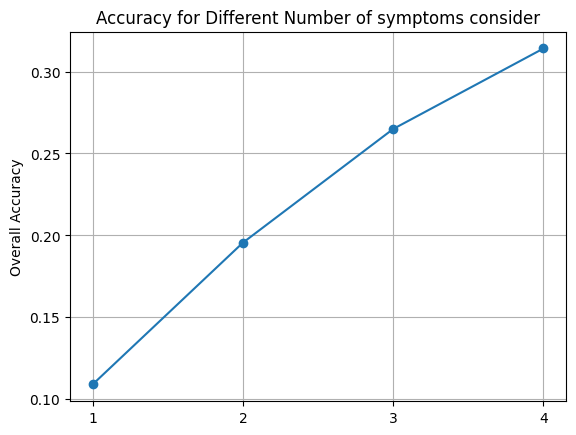

In [ ]:
import matplotlib.pyplot as plt
overall_accuracies = [overall_accuracy1, overall_accuracy2, overall_accuracy3, overall_accuracy4]
num_items_range = range(1, 5)
plt.plot(num_items_range, overall_accuracies, marker='o')

plt.title('Accuracy for Different Number of symptoms consider')
plt.ylabel('Overall Accuracy')
plt.xticks(num_items_range)
plt.grid(True)
plt.show()

### Changing the parameters for node embeddings

In [ ]:
# Generate node embeddings
node2vec = Node2Vec(G, dimensions=256, walk_length=200, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/486 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
node_embeddings = {node: model.wv[node] for node in G.nodes}
# Get embeddings for disease and symptom nodes
disease_embeddings= {node: model.wv[node] for node in G.nodes() if G.nodes[node]['type'] == 'disease'}
symptom_embeddings = {node: model.wv[node] for node in G.nodes() if G.nodes[node]['type'] == 'symptom'}

In [ ]:
node_embeddings_tensor = torch.tensor([node_embeddings[node] for node in node_embeddings], dtype=torch.float)
node_embeddings_array =node_embeddings_tensor.numpy()

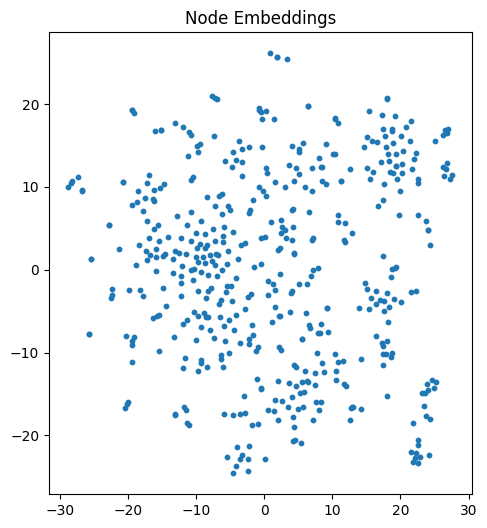

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne= tsne.fit_transform(node_embeddings_array)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=10)
plt.title('Node Embeddings')
plt.show()

In [ ]:
def predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings, disease_list, top_n=4):
    all_similarities = {}
    for disease in disease_list:
        if disease in disease_embeddings:
            disease_embedding = disease_embeddings[disease]
            for symptom_node, symptom_embedding in symptom_embeddings.items():
                similarity = cosine_similarity([disease_embedding], [symptom_embedding])[0][0]
                if symptom_node not in all_similarities:
                    all_similarities[symptom_node] = similarity
                else:
                    all_similarities[symptom_node] += similarity
    # ranking symptoms based on accumulated similarities
    ranked_symptoms = sorted(all_similarities.items(), key=lambda x: x[1], reverse=True)

    # return top predicted symptoms
    top_predicted_symptoms = [symptom for symptom, _ in ranked_symptoms[:top_n]]
    return top_predicted_symptoms

disease_name = ["acid reflux"]

top_predicted_symptoms = predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings, disease_name)
#print(top_predicted_symptoms)

In [ ]:
def extract_top_symptoms_for_all_diseases(G, symptom_embeddings, top_n=4):
    top_symptoms_dict = {}
    for node in G.nodes():
        if G.nodes[node]['type'] == 'disease':
            disease_nodes = [node]
            #print(disease_nodes)
            top_symptoms = predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings, disease_nodes)
            #print(top_symptoms)
            top_symptoms_dict[node] = top_symptoms
            #print(top_symptoms_dict)
    return top_symptoms_dict

predicted_symptoms_all_diseases = extract_top_symptoms_for_all_diseases(G, symptom_embeddings)
#predicted_symptoms_all_diseases

In [ ]:
def calculate_accuracy(true_symptoms, predicted_symptoms, num_items):
    true_symptoms = true_symptoms[:num_items]
    predicted_symptoms = predicted_symptoms[:num_items]
    correct_predictions = sum(symptom in predicted_symptoms for symptom in true_symptoms)
    accuracy = correct_predictions / num_items
    return accuracy
n = 4
top_true_symptoms = extract_top_symptoms_for_disease(data, disease_name)
accuracy = calculate_accuracy(top_predicted_symptoms, top_true_symptoms,n)
#print(f"Accuracy for {disease_name}:", accuracy)

In [ ]:
#top_true_symptoms_all_diseases

**Accuracy for top 1 symptoms**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,1)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy_1 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_1)


Overall accuracy: 0.2564102564102564


**Accuracy for top 2 symptoms**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,2)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy_2 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_2)


Overall accuracy: 0.3814102564102564


**Accuracy for top 3 symptoms**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,3)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy_3 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_3)


Overall accuracy: 0.4273504273504274


**Accuracy for top 4 symptoms**

In [ ]:
accuracies = {}
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease]
    #print(true_symptoms)
    predicted_symptoms = predicted_symptoms_all_diseases.get(disease, [])
    #print(predicted_symptoms)
    accuracy = calculate_accuracy(true_symptoms, predicted_symptoms,4)
    accuracies[disease] = accuracy
# Calculate overall accuracy
overall_accuracy_4 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_4)


Overall accuracy: 0.4823717948717949


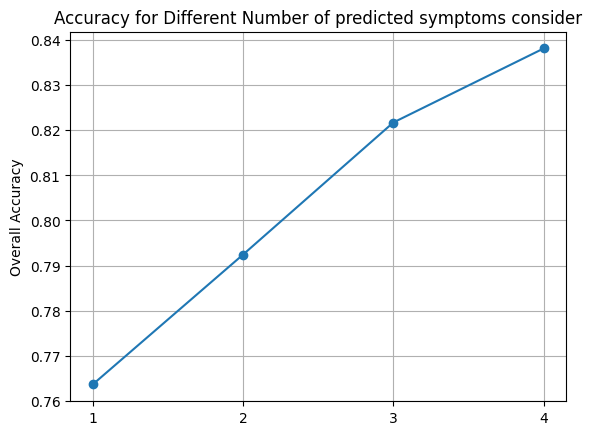

In [ ]:
overall_accuracies = [overall_accuracy_1, overall_accuracy_2, overall_accuracy_3, overall_accuracy_4]
num_items_range = range(1, 5)
plt.plot(num_items_range, overall_accuracies, marker='o')

plt.title('Accuracy for Different Number of predicted symptoms consider')
plt.ylabel('Overall Accuracy')
plt.xticks(num_items_range)
plt.grid(True)
plt.show()

Baseline accuracy for most common symptoms class

In [5]:
# Count the frequency of each symptom across all diseases
symptom_counts = {}
for _, row in data.iterrows():
    symptoms_with_weights = row['Symptoms']
    symptoms = [s.split('(')[0].strip() for s in symptoms_with_weights.split(',')]
    for symptom in symptoms:
        symptom_counts[symptom] = symptom_counts.get(symptom, 0) + 1

# Identify the most common symptoms
most_common_symptoms = sorted(symptom_counts, key=symptom_counts.get, reverse=True)[:1]

In [6]:
correct_true_predictions = 0
total_predictions_top_true = 0
for disease in top_true_symptoms_all_diseases:
    true_symptoms = top_true_symptoms_all_diseases[disease][:1]
    if true_symptoms == most_common_symptoms:
        correct_true_predictions += 1
    total_predictions_top_true += 1

# Calculate accuracy for top true symptoms
accuracy_top_true = correct_true_predictions / total_predictions_top_true if total_predictions_top_true > 0 else 0
print("Accuracy for most common symptom:", accuracy_top_true)

Accuracy for most common symptom: 0.0641025641025641


# Predicting Disease based on symptoms

In [ ]:
def predict_top_diseases_based_on_symptoms(disease_embeddings, symptom_embeddings, symptom_list, top_n=4):
    all_similarities = {}
    for symptom in symptom_list:
        if symptom in symptom_embeddings:
            symptom_embedding = symptom_embeddings[symptom]
            for disease_node, disease_embedding in disease_embeddings.items():
                similarity = cosine_similarity([symptom_embedding], [disease_embedding])[0][0]
                if disease_node not in all_similarities:
                    all_similarities[disease_node] = similarity
                else:
                    all_similarities[disease_node] += similarity

    # ranking diseases based on accumulated similarities
    ranked_diseases = sorted(all_similarities.items(), key=lambda x: x[1], reverse=True)
    top_predicted_diseases = [disease for disease, _ in ranked_diseases[:top_n]]
    return top_predicted_diseases

symptoms_name = ["pain"]

#stores top predicted disease for given symptms
top_predicted_diseases = predict_top_diseases_based_on_symptoms(disease_embeddings, symptom_embeddings, symptoms_name)
print(top_predicted_diseases)


['pancreatitis', 'cholecystitis', 'diverticulitis', 'gallstones']


In [ ]:
def extract_top_disease_for_all_symptoms(G, symptom_embeddings, top_n=4):
    top_diseases_dict = {}
    for node in G.nodes():
        if G.nodes[node]['type'] == 'symptom':
            symptom_nodes = [node]
            #print(disease_nodes)
            top_diseases = predict_top_diseases_based_on_symptoms(disease_embeddings, symptom_embeddings, symptom_nodes)
            #print(top_symptoms)
            top_diseases_dict[node] = top_diseases
            #print(top_symptoms_dict)
    return top_diseases_dict

predicted_diseases_all_symptoms = extract_top_disease_for_all_symptoms(G, symptom_embeddings)

In [ ]:
#predicted_diseases_all_symptoms

In [ ]:
def calculate_accuracy(true_disease, predicted_disease, num_items):
    true_disease = true_disease[:num_items]
    #print(true_disease)
    predicted_disease = predicted_disease[:num_items]
    #print(predicted_disease)
    correct_predictions = sum(disease in predicted_disease for disease in true_disease)
    accuracy = correct_predictions / len(true_disease)
    return accuracy
n=4
top_true_disease = extract_top_disease_for_symptoms(df, symptoms_name)
accuracy = calculate_accuracy(top_predicted_diseases, top_true_disease,n)
#print(f"Accuracy for {symptoms_name}:", accuracy)

**Accuracy for top 1 predicted disease**

In [ ]:
accuracies = {}
for symptom in top_true_disease_all_symptoms:
    true_disease = top_true_disease_all_symptoms[symptom]
    #print(true_disease)
    predicted_diseases = predicted_diseases_all_symptoms.get(symptom, [])
    #print(predicted_diseases)
    accuracy = calculate_accuracy(true_disease, predicted_diseases,1)
    accuracies[symptom] = accuracy
overall_accuracy_1 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_1)


Overall accuracy: 0.7636363636363637


**Accuracy for top 2 predicted diseases**

In [ ]:
accuracies = {}
for symptom in top_true_disease_all_symptoms:
    true_disease = top_true_disease_all_symptoms[symptom]
    #print(true_disease)
    predicted_diseases = predicted_diseases_all_symptoms.get(symptom, [])
    #print(predicted_diseases)
    accuracy = calculate_accuracy(true_disease, predicted_diseases,2)
    accuracies[symptom] = accuracy
overall_accuracy_2 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_2)


Overall accuracy: 0.7924242424242425


**Accuracy for top 3 predicted diseases**

In [ ]:
accuracies = {}
for symptom in top_true_disease_all_symptoms:
    true_disease = top_true_disease_all_symptoms[symptom]
    #print(true_disease)
    predicted_diseases = predicted_diseases_all_symptoms.get(symptom, [])
    #print(predicted_diseases)
    accuracy = calculate_accuracy(true_disease, predicted_diseases,3)
    accuracies[symptom] = accuracy
overall_accuracy_3 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_3)


Overall accuracy: 0.8217171717171716


**Accuracy for top 4 predicted dseases**

In [ ]:
accuracies = {}
for symptom in top_true_disease_all_symptoms:
    true_disease = top_true_disease_all_symptoms[symptom]
    #print(true_disease)
    predicted_diseases = predicted_diseases_all_symptoms.get(symptom, [])
    #print(predicted_diseases)
    accuracy = calculate_accuracy(true_disease, predicted_diseases,4)
    accuracies[symptom] = accuracy
overall_accuracy_4 = sum(accuracies.values()) / len(accuracies)
#for disease, accuracy in accuracies.items():
    #print(f"{disease}: {accuracy}")
print("\nOverall accuracy:", overall_accuracy_4)


Overall accuracy: 0.838131313131313


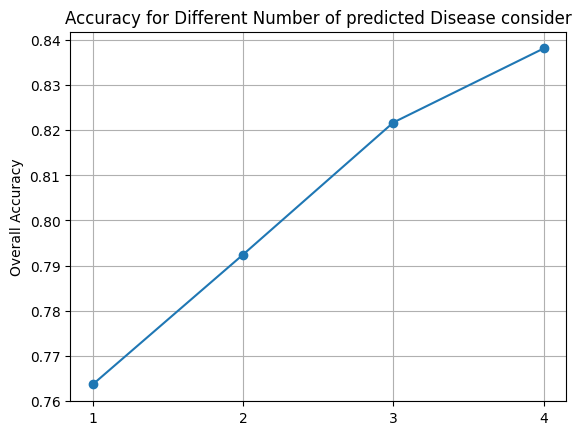

In [ ]:
overall_accuracies = [overall_accuracy_1, overall_accuracy_2, overall_accuracy_3, overall_accuracy_4]
num_items_range = range(1, 5)
plt.plot(num_items_range, overall_accuracies, marker='o')

plt.title('Accuracy for Different Number of predicted Disease consider')
plt.ylabel('Overall Accuracy')
plt.xticks(num_items_range)
plt.grid(True)
plt.show()

# Data Preprocessing

In [ ]:
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\ï½ ', '', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def finalpreprocess(string):
    return stopword(preprocess(string))

#sentence = 'what is the symptoms of migrane? I am having cough from the last few days and feeling like nausea. I am feeling like vomiting as well and feeling tired. I feel like I am having asthma.'

#process_data = finalpreprocess(sentence)

# Function to generate n-grams
def generate_ngrams(text):
    words = text.split()
    all_tokens=[]
    for n in range(1, 6):
        n_grams = ngrams(words, n)
        for grams in n_grams:
            gram_string = ' '.join(grams)
            #print(gram_string)
            all_tokens.append(gram_string)
    return all_tokens

#tokens = generate_ngrams(process_data)

# Print the result
#print(tokens)


# Using Medical-NER

For disease symptoms entity recognition from user input

In [ ]:
from transformers import pipeline
pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')

In [ ]:
def entity_extraction(user_input):
  user_input = finalpreprocess(user_input)
  result = pipe(user_input)
  words = [item['word'] for item in result]
  text_list = words
  return text_list

In [ ]:
def process_user_input(user_input):
  disease_entity = []
  symptom_entity = []
  entities = entity_extraction(user_input)
  #print(entities)
  for entity in entities:
    if entity in symptom_nodes:
      symptom_entity.append(entity)
      #print(f'symptoms{symptom_entity}')
    elif entity in disease_nodes:
      disease_entity.append(entity)
      #print(f'disease{disease_entity}')
  if symptom_entity:
    predicted_disease = predict_top_diseases_based_on_symptoms(disease_embeddings, symptom_embeddings,symptom_entity)
    return predicted_disease
  else :
    predicted_symptoms = predict_top_symptoms_based_on_diseases(disease_embeddings, symptom_embeddings,disease_entity)
    return predicted_symptoms

#### Simple User Interface

 Creating simple user interface for extracting related disease and symptoms based on node embeddings extraction

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def query_symptoms(user_input):
     result_diseases = process_user_input(user_input)
     if result_diseases:
      result_diseases = ', '.join(result_diseases)
      return f"your symptoms can cause {result_diseases}. Stay Safe."
     else:
      return f" I have no information about symptoms {user_input} Can you tell me more about your symptoms."


def query_diseases(user_input):
    result_symptoms = process_user_input(user_input)
    if result_symptoms:
      result_symptoms= ', '.join(result_symptoms)
      return f"If you have {user_input} you might have {result_symptoms}. Stay Safe. "
    else:
      return f" I have no information about disease {user_input}.Please enter another disease."


radio_buttons = widgets.RadioButtons(
    options=['Enter diseases', 'Enter symptoms'],
    description='Choose:'
)
input_field = widgets.Text(
    description='Input:'
)

def update_placeholder(change):
    if change['new'] == 'Enter diseases':
        input_field.placeholder = 'Enter the diseas you want to query '
    elif change['new'] == 'Enter symptoms':
        input_field.placeholder = 'Enter your symptoms'

radio_buttons.observe(update_placeholder, names='value')
output = widgets.Output()
def handle_submit(sender):
    output.clear_output()
    query_type = radio_buttons.value
    user_input = input_field.value
    with output:
        if query_type == 'Enter diseases':
            result = query_diseases(user_input)
        elif query_type == 'Enter symptoms':
            result = query_symptoms(user_input)
        else:
            result = "Invalid query type"
        print(f"your input: {user_input}")
        print(result)
    #input_field.value = ''

submit_button = widgets.Button(description="Submit")
submit_button.on_click(handle_submit)

# Display the form
display(radio_buttons)
display(input_field)
display(submit_button)
display(output)

RadioButtons(description='Choose:', options=('Enter diseases', 'Enter symptoms'), value='Enter diseases')

Text(value='', description='Input:')

Button(description='Submit', style=ButtonStyle())

Output()